In [2]:
# Standard library
import random
import time
from argparse import ArgumentParser

# Third-party
import pytorch_lightning as pl
import torch
from lightning_fabric.utilities import seed

# First-party
from neural_lam import constants, utils
from neural_lam.models.graph_lam import GraphLAM
from neural_lam.models.hi_lam import HiLAM
from neural_lam.models.hi_lam_parallel import HiLAMParallel
from neural_lam.weather_dataset import WeatherDataset


import argparse

# Manually create the args Namespace object with the desired parameters
args = argparse.Namespace(
    dataset='meps_example',
    model='graph_lam',
    subset_ds=0,
    seed=42,
    n_workers=4,
    epochs=200,
    batch_size=1,
    load=None,
    restore_opt=0,
    precision=32,
    graph='1level',
    hidden_dim=32,
    hidden_layers=1,
    processor_layers=1,
    mesh_aggr='sum',
    output_std=0,
    ar_steps=1,
    control_only=0,
    loss='wmse',
    step_length=3,
    lr=0.001,
    val_interval=1,
    eval='test',
    n_example_pred=1
)

print('args', args)
print('args', args.dataset)
MODELS = {
    "graph_lam": GraphLAM,
    "hi_lam": HiLAM,
    "hi_lam_parallel": HiLAMParallel,
}


# Asserts for arguments
assert args.model in MODELS, f"Unknown model: {args.model}"
assert args.step_length <= 3, "Too high step length"
assert args.eval in (
    None,
    "val",
    "test",
), f"Unknown eval setting: {args.eval}"
print('args',args)
# Get an (actual) random run id as a unique identifier
random_run_id = random.randint(0, 9999)

# Set seed
seed.seed_everything(args.seed)

# Load data
train_loader = torch.utils.data.DataLoader(
    WeatherDataset(
        args.dataset,
        pred_length=args.ar_steps,
        split="train",
        subsample_step=args.step_length,
        subset=bool(args.subset_ds),
        control_only=args.control_only,
    ),
    args.batch_size,
    shuffle=True,
    num_workers=args.n_workers,
)
max_pred_length = (65 // args.step_length) - 2  # 19
val_loader = torch.utils.data.DataLoader(
    WeatherDataset(
        args.dataset,
        pred_length=max_pred_length,
        split="val",
        subsample_step=args.step_length,
        subset=bool(args.subset_ds),
        control_only=args.control_only,
    ),
    args.batch_size,
    shuffle=False,
    num_workers=args.n_workers,
)

# Instantiate model + trainer
if torch.cuda.is_available():
    device_name = "cuda"
    torch.set_float32_matmul_precision(
        "high"
    )  # Allows using Tensor Cores on A100s
else:
    device_name = "cpu"

# Load model parameters Use new args for model
model_class = MODELS[args.model]
# if args.load:
#     model = model_class.load_from_checkpoint(args.load, args=args)
#     if args.restore_opt:
#         # Save for later
#         # Unclear if this works for multi-GPU
#         model.opt_state = torch.load(args.load)["optimizer_states"][0]
# else:
#     model = model_class(args)

prefix = "subset-" if args.subset_ds else ""
if args.eval:
    prefix = prefix + f"eval-{args.eval}-"
run_name = (
    f"{prefix}{args.model}-{args.processor_layers}x{args.hidden_dim}-"
    f"{time.strftime('%m_%d_%H')}-{random_run_id:04d}"
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"saved_models/{run_name}",
    filename="min_val_loss",
    monitor="val_mean_loss",
    mode="min",
    save_last=True,
)
logger = pl.loggers.WandbLogger(
    project=constants.WANDB_PROJECT, name=run_name, config=args
)
trainer = pl.Trainer(
    max_epochs=args.epochs,
    deterministic=True,
    strategy="ddp_notebook",
    accelerator=device_name,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=args.val_interval,
    precision=args.precision,
)

# Only init once, on rank 0 only
if trainer.global_rank == 0:
    utils.init_wandb_metrics(logger)  # Do after wandb.init

if args.eval:
    if args.eval == "val":
        eval_loader = val_loader
    else:  # Test
        eval_loader = torch.utils.data.DataLoader(
            WeatherDataset(
                args.dataset,
                pred_length=max_pred_length,
                split="test",
                subsample_step=args.step_length,
                subset=bool(args.subset_ds),
            ),
            args.batch_size,
            shuffle=False,
            num_workers=args.n_workers,
        )

    print(f"Running evaluation on {args.eval}")
    # trainer.test(model=model, dataloaders=eval_loader)
else:
    # Train model
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )


Seed set to 42


args Namespace(dataset='meps_example', model='graph_lam', subset_ds=0, seed=42, n_workers=4, epochs=200, batch_size=1, load=None, restore_opt=0, precision=32, graph='1level', hidden_dim=32, hidden_layers=1, processor_layers=1, mesh_aggr='sum', output_std=0, ar_steps=1, control_only=0, loss='wmse', step_length=3, lr=0.001, val_interval=1, eval='test', n_example_pred=1)
args meps_example
args Namespace(dataset='meps_example', model='graph_lam', subset_ds=0, seed=42, n_workers=4, epochs=200, batch_size=1, load=None, restore_opt=0, precision=32, graph='1level', hidden_dim=32, hidden_layers=1, processor_layers=1, mesh_aggr='sum', output_std=0, ar_steps=1, control_only=0, loss='wmse', step_length=3, lr=0.001, val_interval=1, eval='test', n_example_pred=1)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 4x1fhfhd.


Running evaluation on test


In [3]:
#Trace and show diagram
import torch
from graphviz import Digraph

def plot_simplified_model_io_graph(io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz.
    
    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, top_level_module_name, shape='box')

        # Only show unique input tensors to avoid clutter
        for input_name in input_names:
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name)

        # Only show unique output tensors to avoid clutter
        for output_name in output_names:
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name)

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Save the graph to a file and render it
    dot.render(output_file, format=format)

    return dot

def trace_lightning_model_io_with_loader(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names).
    """
    io_dict = {}
    tensor_id_to_name = {}
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)

            # Record the outputs
            output_names = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict



hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers
model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr,lr, dataset, output_std, loss, step_length, n_example_pred,graph,processor_layers)



model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O
model_io = trace_lightning_model_io_with_loader(model, eval_loader)

# Plot the simplified model I/O graph
graph = plot_simplified_model_io_graph(model_io, output_file='simplified_model_io_graph', format='png', dpi=300)

# Print the module I/O information in the desired format
for module_name, (input_names, output_names) in model_io.items():
    print(f"Module: {module_name}")
    for input_name in input_names:
        print(f"  Input Tensor: {input_name}")
    for output_name in output_names:
        print(f"  Output Tensor: {output_name}")

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136
Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136
Module: grid_embedder
  Input Tensor: grid_embedder_input_0
  Output Tensor: grid_embedder_output_0
Module: g2m_embedder
  Input Tensor: g2m_embedder_input_0
  Output Tensor: g2m_embedder_output_0
Module: m2g_embedder
  Input Tensor: m2g_embedder_input_0
  Output Tensor: m2g_embedder_output_0
Module: mesh_embedder
  Input Tensor: mesh_embedder_input_0
  Output Tensor: mesh_embedder_output_0
Module: g2m_gnn
  Input Tensor: grid_embedder_output_0
  Input Tensor: processor_output_0
  Input Tensor: processor_output_0
  Output Tensor: g2m_gnn_output_0
Module: encoding_grid_mlp
  Input Tensor: grid_embedder_output_0
  Output Tensor: encoding_grid_mlp_output_0
Module: m2m_embedder
  Input Tensor: m2m_embedder_input_0
  Output Tensor: m2m_embedder_output_0
Module: processor
  Input

In [4]:
import torch
from graphviz import Digraph

def plot_simplified_model_io_graph_with_order(io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, top_level_module_name, shape='box')

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Save the graph to a file and render it
    dot.render(output_file, format=format)

    return dot

def trace_lightning_model_io_with_order(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict

In [5]:
from IPython.display import Image, display
import torch
from graphviz import Digraph

def plot_simplified_model_io_graph_with_order(io_dict, format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.
    
    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, top_level_module_name, shape='box')

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Example usage:
# graph = plot_simplified_model_io_graph_with_order(model_io)

In [6]:

hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers
model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr,lr, dataset, output_std, loss, step_length, n_example_pred,graph,processor_layers)



model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Trace the model I/O
model_io = trace_lightning_model_io_with_loader(model, eval_loader)

# Plot the simplified model I/O graph
graph = plot_simplified_model_io_graph(model_io, output_file='simplified_model_io_graph', format='png', dpi=300)

# Print the module I/O information in the desired format
for module_name, (input_names, output_names) in model_io.items():
    print(f"Module: {module_name}")
    for input_name in input_names:
        print(f"  Input Tensor: {input_name}")
    for output_name in output_names:
        print(f"  Output Tensor: {output_name}")

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136
Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136
Module: grid_embedder
  Input Tensor: grid_embedder_output_0
  Output Tensor: grid_embedder_output_0
Module: g2m_embedder
  Input Tensor: g2m_embedder_input_0
  Output Tensor: g2m_embedder_output_0
Module: m2g_embedder
  Input Tensor: m2g_embedder_input_0
  Output Tensor: m2g_embedder_output_0
Module: mesh_embedder
  Input Tensor: mesh_embedder_input_0
  Output Tensor: mesh_embedder_output_0
Module: g2m_gnn
  Input Tensor: grid_embedder_output_0
  Input Tensor: g2m_embedder_output_0
  Input Tensor: g2m_embedder_output_0
  Output Tensor: g2m_gnn_output_0
Module: encoding_grid_mlp
  Input Tensor: grid_embedder_output_0
  Output Tensor: encoding_grid_mlp_output_0
Module: m2m_embedder
  Input Tensor: m2m_embedder_input_0
  Output Tensor: m2m_embedder_output_0
Module: processor


In [7]:
graph = plot_simplified_model_io_graph_with_order(model_io)

ValueError: not enough values to unpack (expected 3, got 2)

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


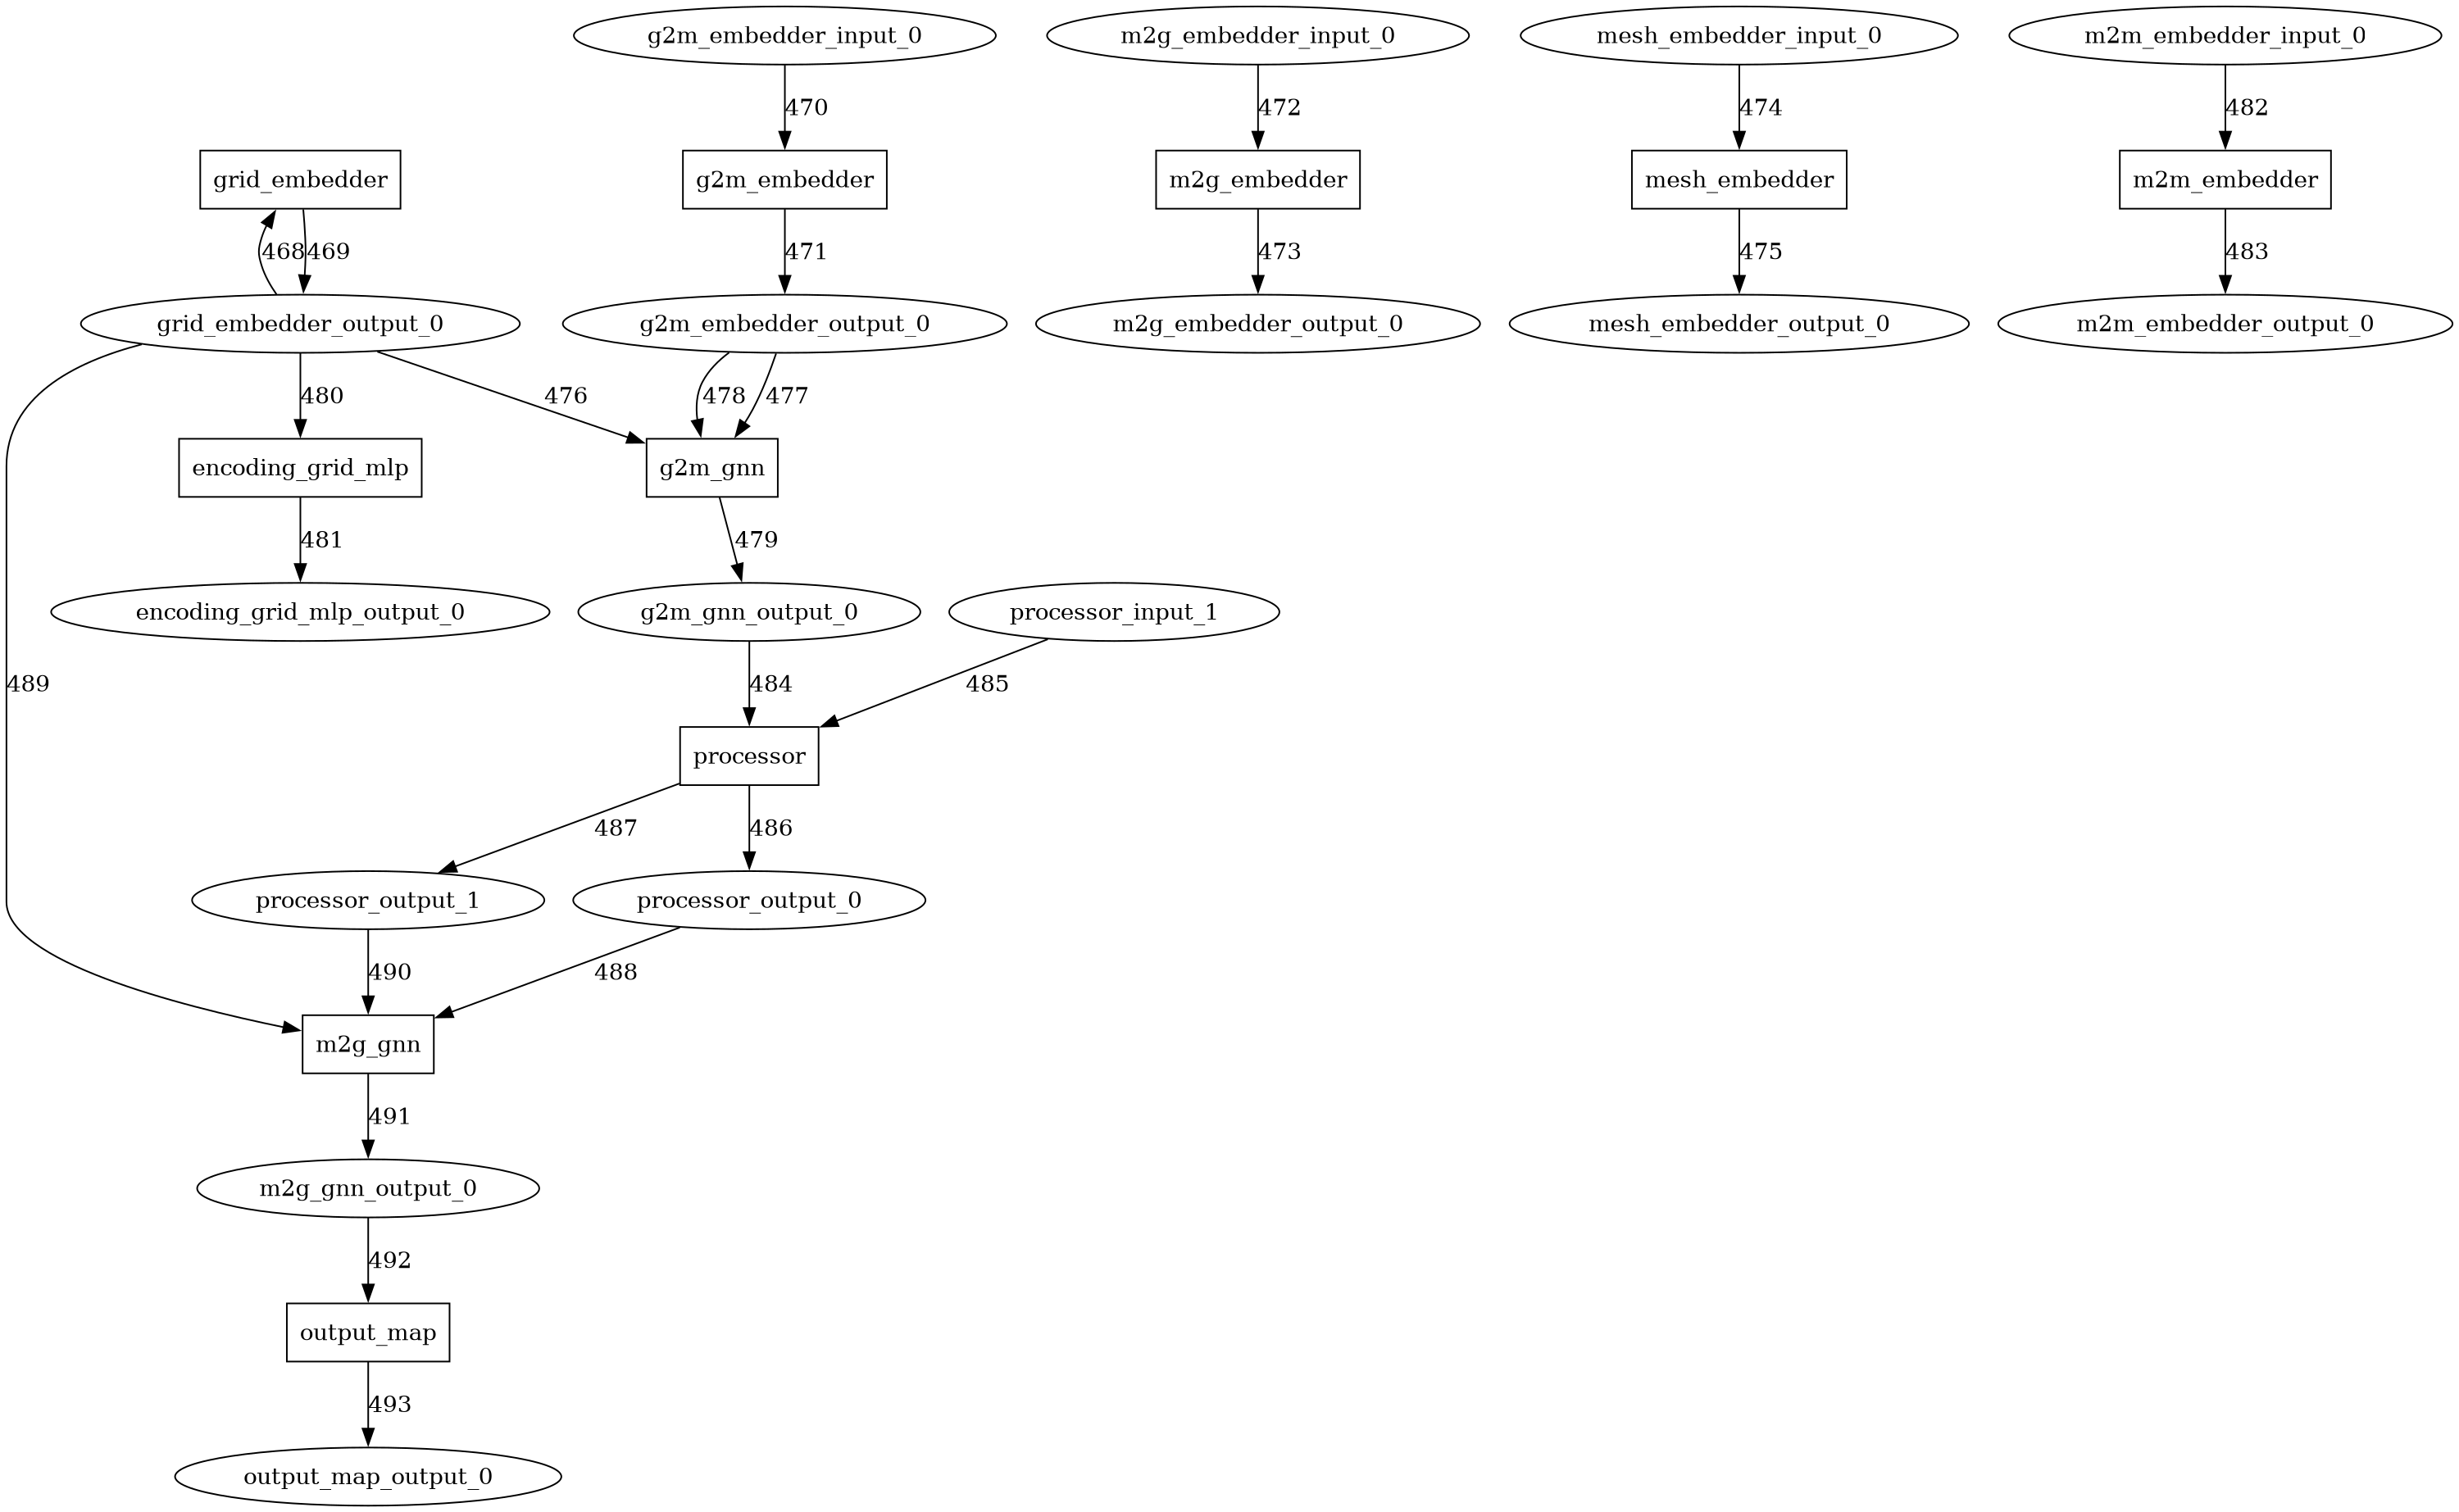

In [ ]:
import torch
from graphviz import Digraph

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict

def plot_simplified_model_io_graph_with_order_and_track(io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, top_level_module_name, shape='box')

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers
model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr,lr, dataset, output_std, loss, step_length, n_example_pred,graph,processor_layers)


# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections and tracking
graph = plot_simplified_model_io_graph_with_order_and_track(model_io)

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


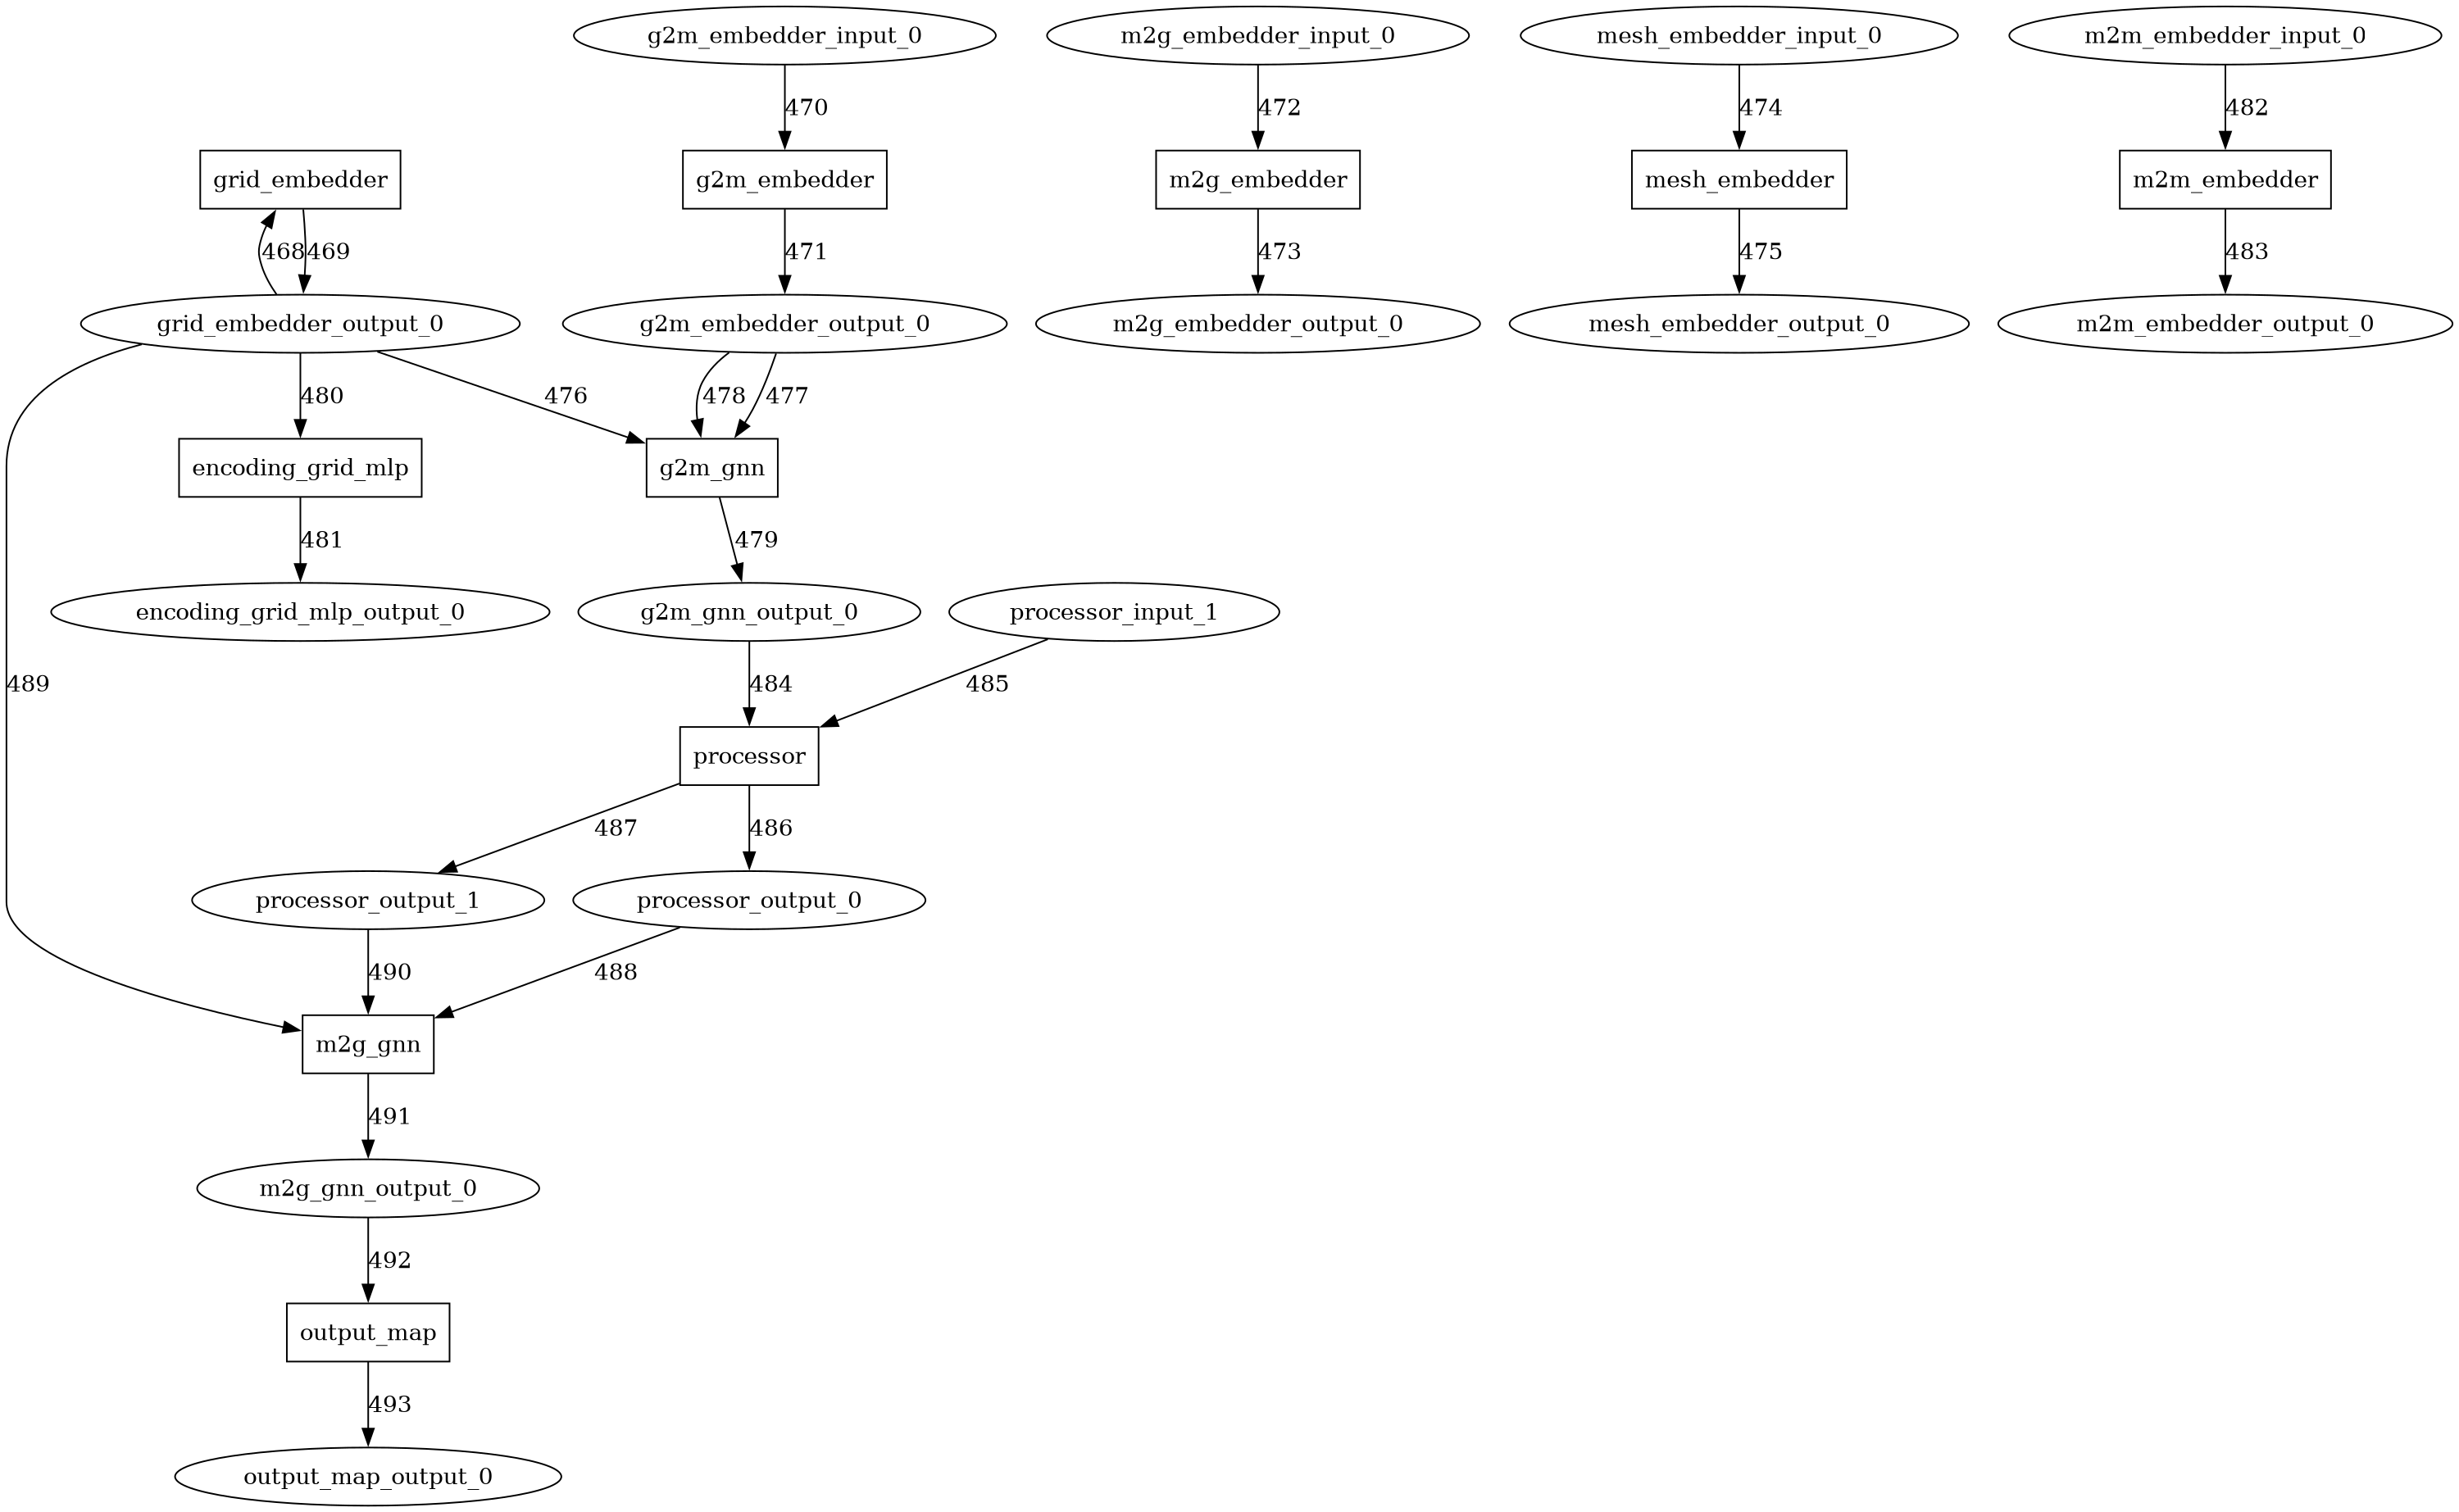

In [ ]:
import torch
from graphviz import Digraph

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict

def plot_simplified_model_io_graph_with_order_and_track(io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, top_level_module_name, shape='box')

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections and tracking
graph = plot_simplified_model_io_graph_with_order_and_track(model_io)

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


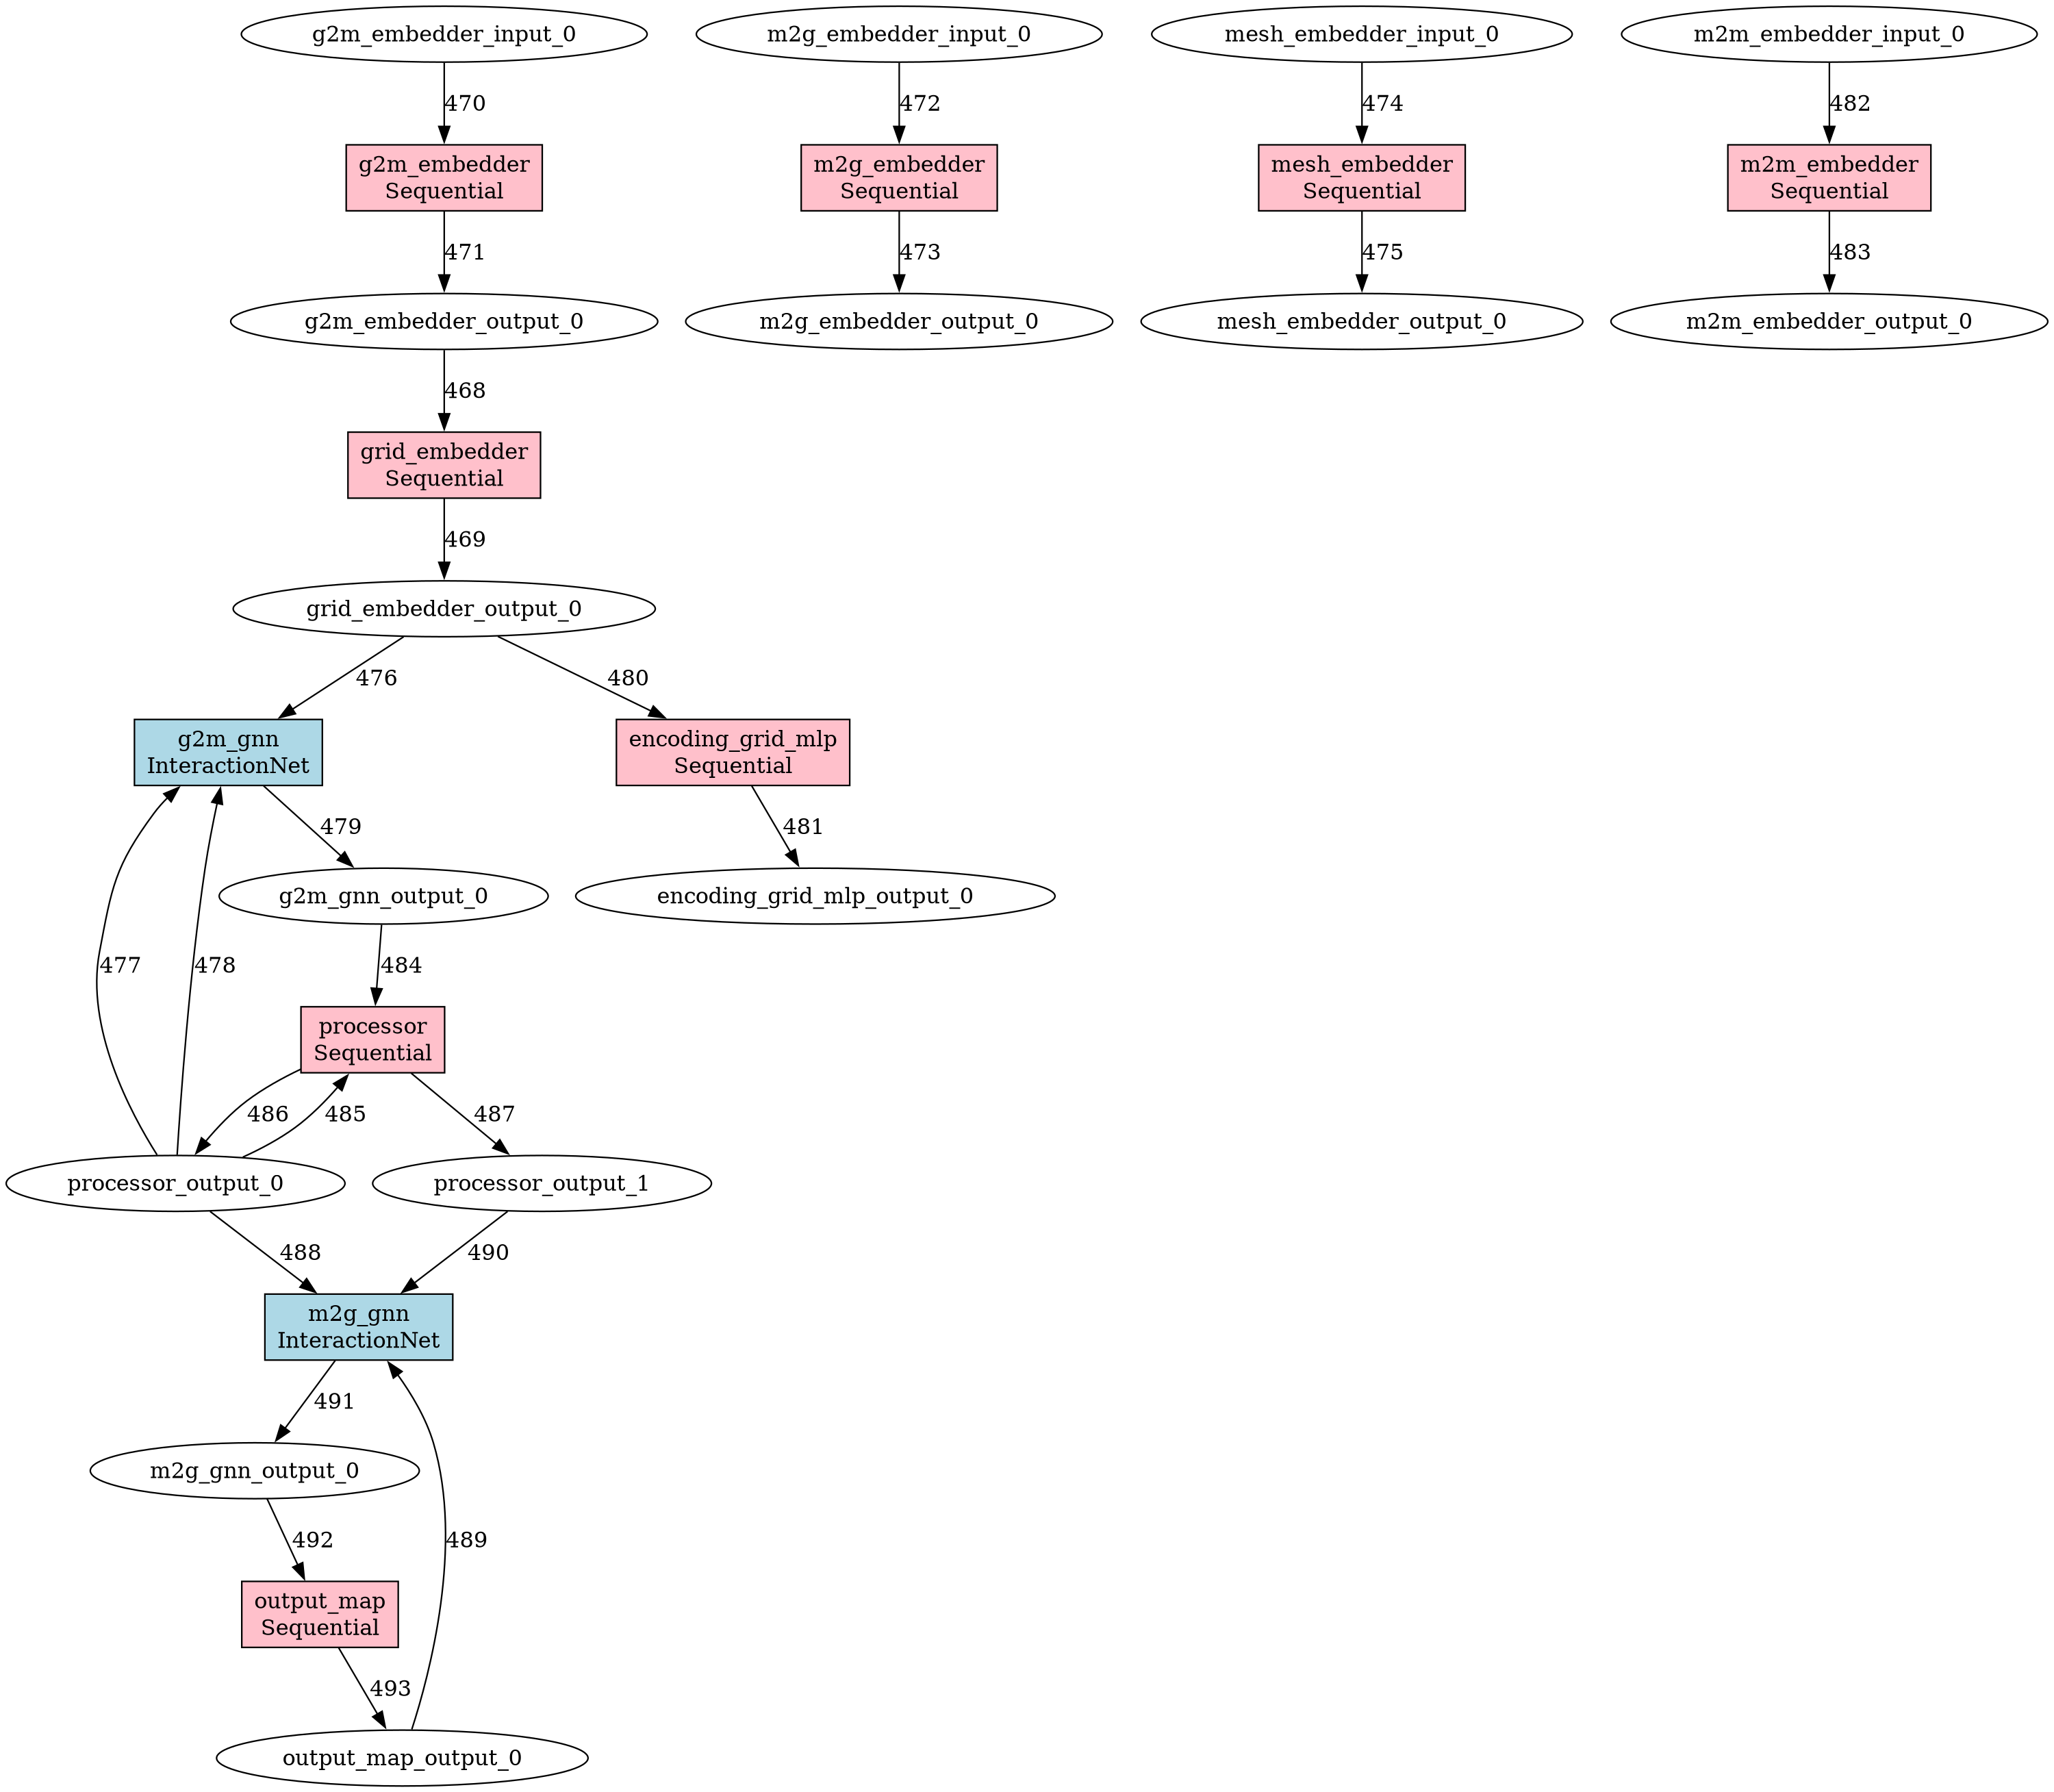

In [ ]:
import torch
from graphviz import Digraph
from neural_lam import utils
from neural_lam.interaction_net import InteractionNet

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    module_info = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            
            # Extract feature/channel count (input and output sizes)
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
                feature_count = f"{inputs[0].size(1)} -> {outputs.size(1)}"
            elif isinstance(module, torch.nn.Sequential):
                feature_count = "Sequential"
            elif isinstance(module, InteractionNet):
                feature_count = "InteractionNet"
            else:
                feature_count = f"{type(module).__name__}"

            # Save the module type and feature count
            module_info[top_level_module_name] = feature_count

            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict, module_info

def plot_simplified_model_io_graph_with_order_and_track(io_dict, module_info, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        module_info (dict): A dictionary mapping module names to their types and feature counts.
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    # Define colors based on module types
    module_colors = {
        'InteractionNet': 'lightblue',
        'Linear': 'lightgreen',
        'Conv2d': 'orange',
        'Sequential': 'pink'
    }

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]
        module_label = f"{top_level_module_name}\n{module_info.get(top_level_module_name, '')}"

        # Set color based on module type
        node_color = module_colors.get(module_info.get(top_level_module_name, ''), 'white')

        # Create a node for the top-level module with color and feature count
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, module_label, shape='box', style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io, module_info = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections, tracking, and annotations
graph = plot_simplified_model_io_graph_with_order_and_track(model_io, module_info)

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


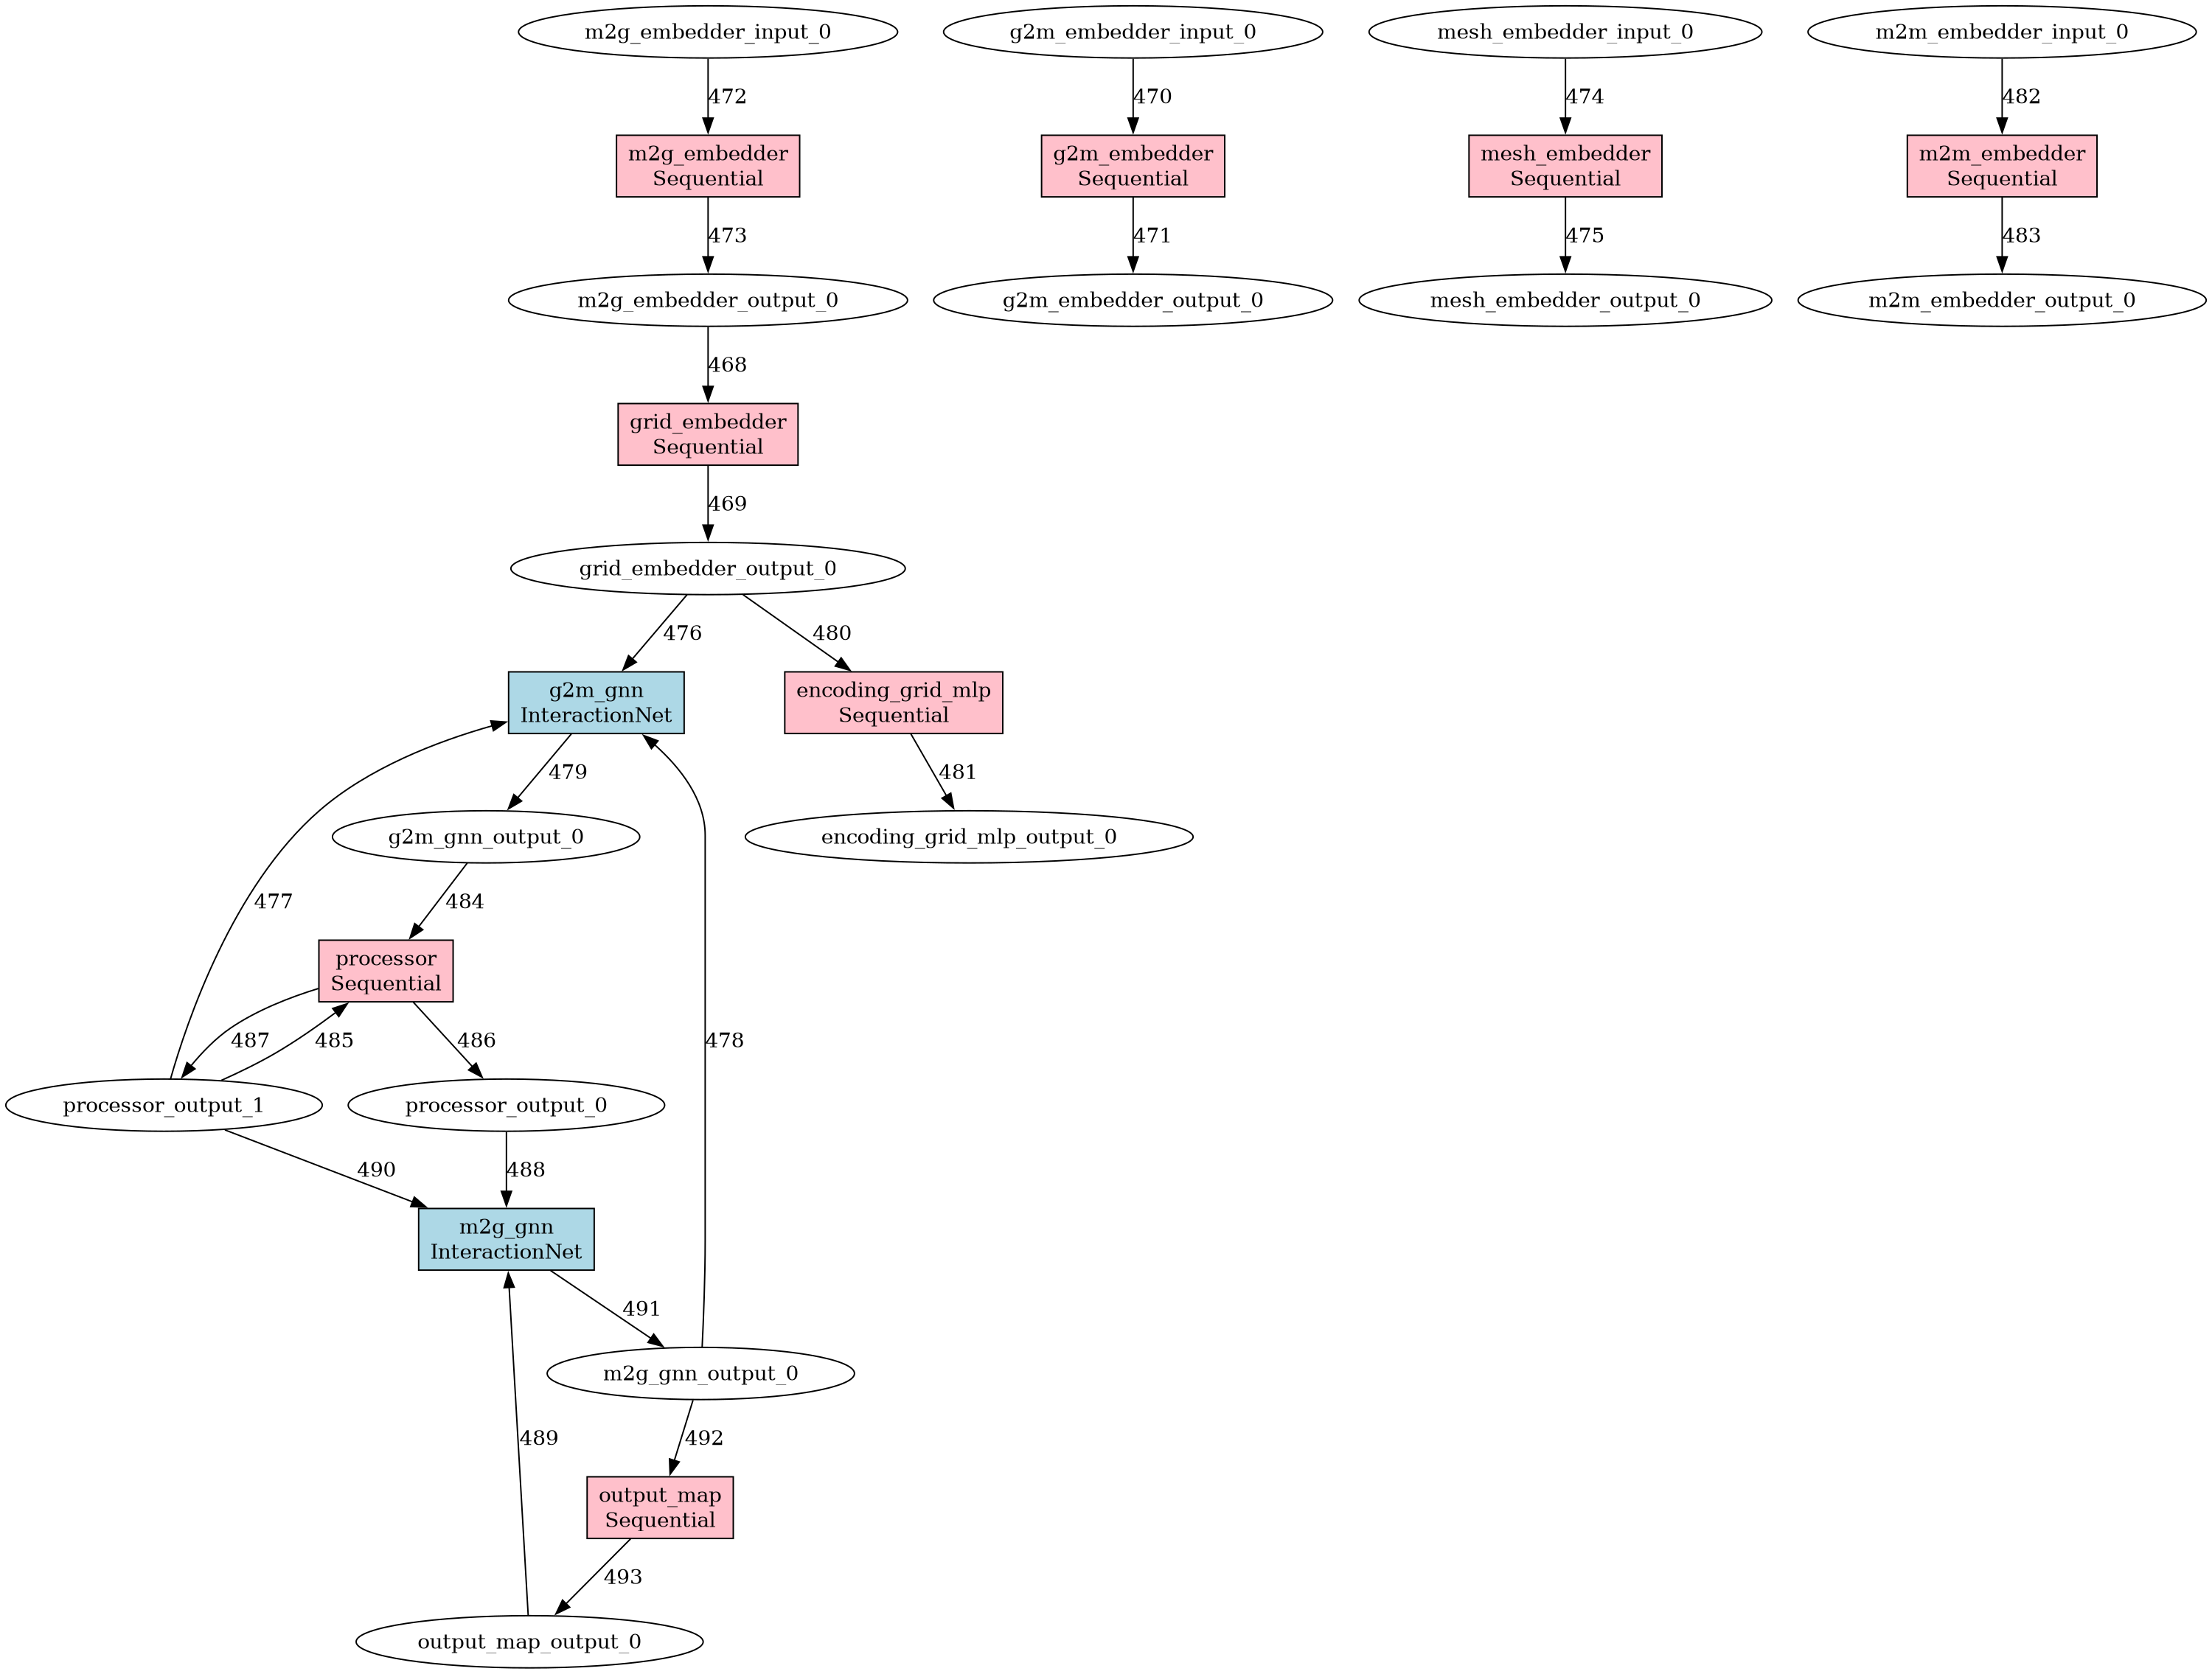

In [ ]:
import torch
from graphviz import Digraph
from neural_lam import utils
from neural_lam.interaction_net import InteractionNet
from IPython.display import Image, display

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    module_info = {}
    order_counter = 0

    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            
            # Extract feature/channel count (input and output sizes)
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
                feature_count = f"{inputs[0].size(1)} -> {outputs.size(1)}"
            elif isinstance(module, torch.nn.Sequential):
                feature_count = "Sequential"
            elif isinstance(module, InteractionNet):
                feature_count = "InteractionNet"
            else:
                feature_count = f"{type(module).__name__}"

            # Save the module type and feature count
            module_info[top_level_module_name] = feature_count

            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    # If tensor was expanded, track the original
                    if inp.shape[0] != inputs[0].shape[0]:
                        inp = inputs[0]
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict, module_info

def plot_simplified_model_io_graph_with_order_and_track(io_dict, module_info, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        module_info (dict): A dictionary mapping module names to their types and feature counts.
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    # Define colors based on module types
    module_colors = {
        'InteractionNet': 'lightblue',
        'Linear': 'lightgreen',
        'Conv2d': 'orange',
        'Sequential': 'pink'
    }

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]
        module_label = f"{top_level_module_name}\n{module_info.get(top_level_module_name, '')}"

        # Set color based on module type
        node_color = module_colors.get(module_info.get(top_level_module_name, ''), 'white')

        # Create a node for the top-level module with color and feature count
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, module_label, shape='box', style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot



# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)
# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io, module_info = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections, tracking, and annotations
graph = plot_simplified_model_io_graph_with_order_and_track(model_io, module_info)

Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


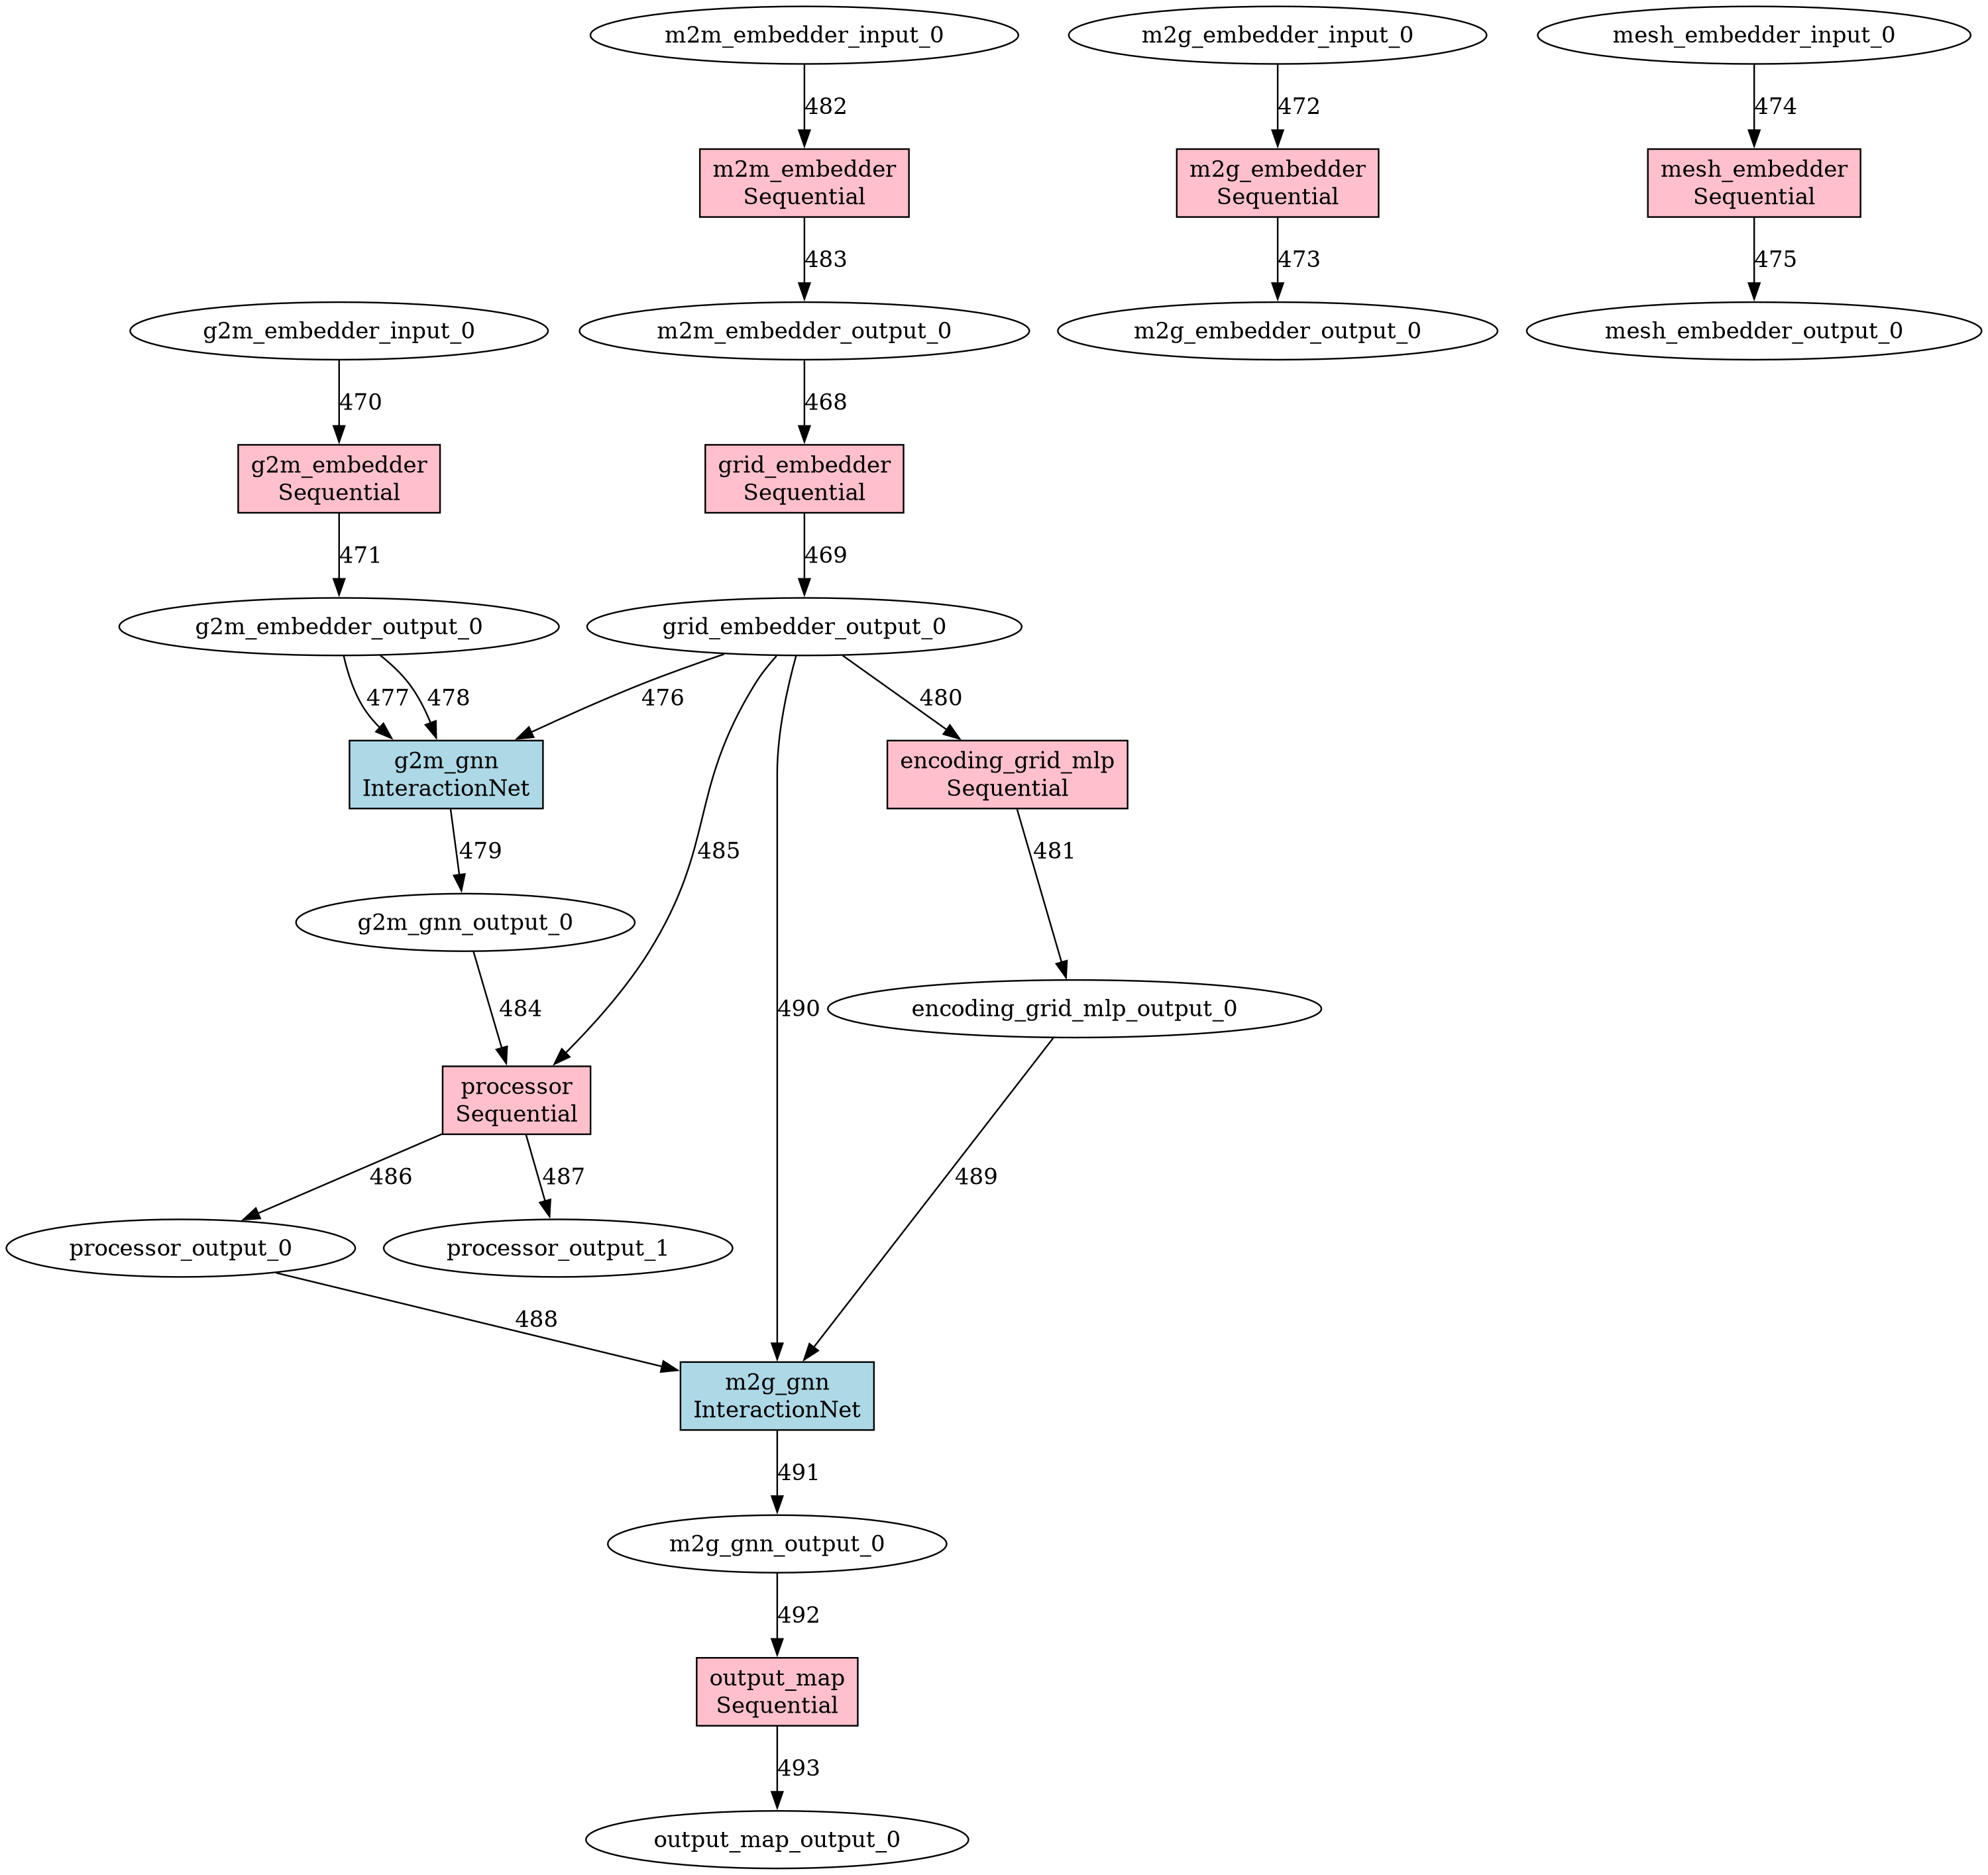

In [ ]:
import torch
from graphviz import Digraph
from neural_lam import utils
from neural_lam.interaction_net import InteractionNet
from IPython.display import Image, display

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    module_info = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            
            # Extract feature/channel count (input and output sizes)
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d)):
                feature_count = f"{inputs[0].size(1)} -> {outputs.size(1)}"
            elif isinstance(module, torch.nn.Sequential):
                feature_count = "Sequential"
            elif isinstance(module, InteractionNet):
                feature_count = "InteractionNet"
            else:
                feature_count = f"{type(module).__name__}"

            # Save the module type and feature count
            module_info[top_level_module_name] = feature_count

            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    # Handle expanded tensors by looking at the original tensor
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict, module_info

def plot_simplified_model_io_graph_with_order_and_track(io_dict, module_info, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations.

    Args:
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        module_info (dict): A dictionary mapping module names to their types and feature counts.
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    # Define colors based on module types
    module_colors = {
        'InteractionNet': 'lightblue',
        'Linear': 'lightgreen',
        'Conv2d': 'orange',
        'Sequential': 'pink'
    }

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]
        module_label = f"{top_level_module_name}\n{module_info.get(top_level_module_name, '')}"

        # Set color based on module type
        node_color = module_colors.get(module_info.get(top_level_module_name, ''), 'white')

        # Create a node for the top-level module with color and feature count
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, module_label, shape='box', style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io, module_info = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections, tracking, and annotations
graph = plot_simplified_model_io_graph_with_order_and_track(model_io, module_info)

In [ ]:
import torch
from graphviz import Digraph

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict

def get_node_color(module):
    """
    Returns the color for the node based on the module type.
    """
    if isinstance(module, torch.nn.Linear):
        return 'lightblue'
    elif isinstance(module, InteractionNetWrapper):
        return 'lightgreen'
    elif isinstance(module, torch.nn.Sequential):
        return 'orange'
    # Add other module types as needed
    return 'white'  # Default color

def plot_simplified_model_io_graph_with_order_and_track(model, io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations, and includes color-coding
    and annotations for the feature/channel count.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model.
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Get the module and determine its color and shape
        module = dict(model.named_modules())[top_level_module_name]
        node_color = get_node_color(module)
        shape = 'box' if node_color != 'white' else 'ellipse'

        # Annotate the node with feature/channel count
        annotation = f"{top_level_module_name}\nFeatures: {module.out_features if hasattr(module, 'out_features') else 'N/A'}"
        
        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, annotation, shape=shape, style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections and tracking
graph = plot_simplified_model_io_graph_with_order_and_track(model, model_io)


NameError: name 'args' is not defined